In [325]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as k
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Lambda, LSTM, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Functions

 ## dataset loading

In [326]:
# load authors texts into dataframe
# folder paths should contain txt files containing articles written by each other
# left path specifics primary author to verify
# right path specifics other author or authors
def load_data_from_folder(path_left, path_right):
    df = pd.DataFrame(columns=['text', 'sequence', 'path'])
    
    for file in os.listdir(path_left):
        with open(os.path.join(path_left, file), 'r') as f:
            text = f.read()
        df.loc[len(df)] = [text, None, 'left']
        
    left_len = df.shape[0]
        
    for file in os.listdir(path_right):
        with open(os.path.join(path_right, file), 'r') as f:
            text = f.read()
        df.loc[len(df)] = [text, None, 'right']
    
    right_len = df.shape[0] - left_len
    
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(df['text'])
    df.loc[:, 'sequence'] = tokenizer.texts_to_sequences(df['text'])
        
    return df, left_len, right_len

In [327]:
# loads author texts into dataframe
# csv format: "id","text","author" with headers
# csv file should include authors 0 and 1 for left and right paths
def load_data_from_csv(csv_path, size):
    csv_df = pd.read_csv(csv_path)
    
    # left_len = len(csv_df.query('author == 0'))
    # right_len = len(csv_df.query('author == 1'))
    
    df = pd.concat([csv_df.query('author == 0').sample(n=size)], ignore_index=True)
    df = pd.concat([df, csv_df.query('author == 1').sample(n=size)], ignore_index=True)
    df = df.drop(columns=['id'])
    df.rename(columns={'author':'path'} , inplace=True)
    df['path'] = df['path'].replace({0:"left", 1:"right"})
        
    df.insert(1, 'sequence', None)
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(df['text'])
    df.loc[:, 'sequence'] = np.asarray(tokenizer.texts_to_sequences(df['text']), dtype='object')
    
    return df, size, size

## dataset manipulation

In [328]:
# create paired data with sequence1 sequence2 label columns
# df needs to contain sequence and path columns
# it will be half the size of one author dataset
# and will contain half rows with same author articles
# and other half rows with different author articles
def create_paired_data(df, size):
    quarter_left_size = size // 4
    paired_df = pd.DataFrame(columns=['sequence1', 'sequence2', 'label'])
    
    # set sequences to all left-path articles
    paired_df['sequence1'] = df.query('path == "left"').sample(frac=0.5, ignore_index=True)['sequence']
    paired_df['sequence2'] = df.query('path == "left"').sample(frac=0.5, ignore_index=True)['sequence']
    
    # set the second half of sequence2 to right-path articles
    paired_df.loc[quarter_left_size:, 'sequence2'] = df.query('path == "right"').sample(frac=0.5, ignore_index=True)['sequence']
    
    # set label data
    paired_df.loc[0:quarter_left_size, 'label'] = 1
    paired_df.loc[quarter_left_size:, 'label'] = 0
    
    return paired_df

In [329]:
# splits paired dataframe into train and test splits
# train_frac determines what percentage of data will go to the training set
# the rest goes to testing set
def create_split_data(paired_df, train_frac):
    train_df = paired_df.sample(frac=train_frac)
    train_df.reset_index(drop=True, inplace=True)

    test_df = paired_df.sample(frac=(1-train_frac))
    test_df.reset_index(drop=True, inplace=True)
    
    return train_df, test_df

In [330]:
# create model input ndarrays from train/test dataframes
# seq_len determines the length of each final sequence
# texts shorter than seq_len will be padded
# texts longer than seq_len will be truncated
# outputs can be used directly on model
def create_input_data(train_df, test_df, seq_len):
    train_left = np.zeros(shape=(len(train_df), seq_len))
    for i in range(len(train_df)):
        for j in range(len(train_df.sequence1[i])):
            if j < seq_len:
                train_left[i][j] = train_df.sequence1[i][j]
            else:
                break
                
    train_right = np.zeros(shape=(len(train_df), seq_len))
    for i in range(len(train_df)):
        for j in range(len(train_df.sequence2[i])):
            if j < seq_len:
                train_right[i][j] = train_df.sequence2[i][j]
            else:
                break
                
    test_left = np.zeros(shape=(len(test_df), seq_len))
    for i in range(len(test_df)):
        for j in range(len(test_df.sequence1[i])):
            if j < seq_len:
                test_left[i][j] = test_df.sequence1[i][j]
            else:
                break
                
    test_right = np.zeros(shape=(len(test_df), seq_len))
    for i in range(len(test_df)):
        for j in range(len(test_df.sequence2[i])):
            if j < seq_len:
                test_right[i][j] = test_df.sequence2[i][j]
            else:
                break
                
    labels_train = np.zeros(shape=(len(train_df)))
    for i in range(len(train_df)):
        labels_train[i] = train_df.label[i]
        
    labels_test = np.zeros(shape=(len(test_df)))
    for i in range(len(test_df)):
        labels_test[i] = test_df.label[i]
        
    return train_left, train_right, test_left, test_right, labels_train, labels_test

## print statistics

In [331]:
def print_history_plot(hist, epo_num):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['loss'])
    plt.axis([0, epo_num, 0, 1])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy','loss'], loc='lower left')
    plt.show()

In [332]:
def print_confusion_matrix(model, x_test_left, x_test_right, y_test):
    pred = model.predict([x_test_left, x_test_right], verbose=0)
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Different', 'Same'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## learning model

In [333]:
# euclidean distance between two sequence vectors
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
def euclidean_distance(vects):
	x, y = vects
	return k.sqrt(k.maximum(k.sum(k.square(x - y), axis=1, keepdims=True), k.epsilon()))

In [334]:
# returns shapes for euclidean distances
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
def eucl_dist_output_shape(shapes):
	shape1, shape2 = shapes	
	return shape1[0], 1

In [335]:
# single neural network model for siamese architecture
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
# slightly edited for input size
def siamese_architecture(input_size):
    single_model = Sequential()
    single_model.add(Conv1D(filters=75, kernel_size=12, padding='same', activation='relu'))
    single_model.add(BatchNormalization())
    single_model.add(Activation('relu'))
    single_model.add(Dropout(0.1))
    single_model.add(Conv1D(50, 12))
    single_model.add(Activation('relu'))
    single_model.add(BatchNormalization())
    single_model.add(Dropout(0.1))
    single_model.add(MaxPooling1D(4))
    single_model.add(LSTM(64, recurrent_dropout=0.1, return_sequences=False))
    single_model.add(Activation('relu'))
    single_model.build(input_shape=(None, input_size, 1))
    return single_model

In [336]:
# full siamese model using two neural networks
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
def siamese_model(seq_len):
    single_model = siamese_architecture(seq_len)
    input1 = Input(shape=(seq_len, 1))
    input2 = Input(shape=(seq_len, 1))
    left_branch = single_model(input1)
    right_branch = single_model(input2)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([left_branch, right_branch])
    full_model = Model(inputs=[input1, input2], outputs=distance)
    full_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return full_model

# Program

## Parameters

In [337]:
# parameters
sequence_len = 500          # length of each text sequence
batch_size = 16             # batch size for training
epochs_num = 16             # number of epochs to train on
train_frac_size = 0.7       # fraction of data to use for training set

## data setup

In [338]:
# load data
dataframe, left_size, right_size = load_data_from_folder('./data/AaronPressman', './data/EdnaFernandes')
# dataframe, left_size, right_size = load_data_from_csv('./data/spooky_dataset.csv', 300)

# print data as loaded
display(dataframe)

,text,sequence,path
0,The Internet may be overflowing with new techn...,"[1, 32, 129, 12, 5025, 14, 34, 248, 18, 2493, ...",left
1,The U.S. Postal Service announced Wednesday a ...,"[1, 51, 53, 2497, 168, 378, 194, 4, 80, 2, 933...",left
2,Elementary school students with access to the ...,"[5081, 1412, 3017, 14, 117, 2, 1, 32, 3018, 48...",left
3,An influential Internet organisation has backe...,"[30, 2183, 32, 935, 25, 1046, 878, 21, 4, 212,...",left
4,An influential Internet organisation has backe...,"[30, 2183, 32, 935, 25, 1046, 878, 21, 4, 212,...",left
...,...,...,...
195,Crucial talks between the British and U.S. gov...,"[2472, 289, 228, 1, 66, 5, 51, 53, 849, 8, 365...",right
196,"BAA Plc, the British airports group behind Eur...","[1536, 167, 1, 66, 1037, 46, 665, 4951, 554, 7...",right
197,Britain's opposition Labour Party outlined its...,"[394, 736, 375, 677, 1188, 24, 3548, 10, 446, ...",right
198,Britain could raise between 600 million and 1....,"[218, 58, 470, 228, 1020, 20, 5, 45, 157, 72, ...",right


In [339]:
# pair text sequences of same/different authors
paired_dataframe = create_paired_data(dataframe, left_size)

# print paired texts and labels
display(paired_dataframe)

,sequence1,sequence2,label
0,"[4, 133, 2267, 2563, 21, 3189, 4, 3941, 2638, ...","[1, 51, 53, 2497, 168, 378, 194, 4, 80, 2, 933...",1
1,"[231, 2, 1131, 1170, 51, 53, 70, 474, 8, 133, ...","[30, 2183, 380, 750, 46, 11, 2570, 968, 8, 69,...",1
2,"[354, 358, 603, 297, 2740, 4, 80, 2, 1319, 123...","[99, 465, 95, 1602, 670, 8, 293, 765, 65, 2, 3...",1
3,"[1, 671, 3, 329, 810, 34, 1010, 153, 5, 1654, ...","[1, 32, 129, 12, 5025, 14, 34, 248, 18, 2493, ...",1
4,"[32, 117, 362, 5, 487, 89, 802, 14, 313, 3266,...","[1, 2354, 5956, 49, 10, 952, 191, 1184, 58, 12...",1
5,"[30, 150, 32, 46, 950, 24, 80, 194, 2, 1131, 5...","[4, 133, 2267, 2563, 21, 3189, 4, 3941, 2638, ...",1
6,"[30, 150, 1064, 990, 1043, 14, 2258, 1, 3905, ...","[32, 117, 362, 5, 487, 89, 802, 14, 313, 3266,...",1
7,"[73, 129, 12, 211, 48, 3418, 2, 2021, 2211, 34...","[1, 178, 98, 25, 4327, 4, 80, 2, 324, 216, 211...",1
8,"[1, 51, 53, 55, 11, 2280, 2, 1805, 1139, 3, 13...","[1, 99, 158, 272, 25, 2621, 836, 31, 735, 444,...",1
9,"[1, 99, 465, 129, 31, 12, 737, 3298, 6025, 2, ...","[231, 2, 1131, 1170, 51, 53, 70, 474, 8, 133, ...",1


In [340]:
# split train and test sets
# label 0 - different authors texts
# label 1 - same author texts
train_dataframe, test_dataframe = create_split_data(paired_dataframe, train_frac_size)

# display train and test sets
display(train_dataframe)
display(test_dataframe)

,sequence1,sequence2,label
0,"[30, 150, 1064, 990, 1043, 14, 2258, 1, 3905, ...","[32, 117, 362, 5, 487, 89, 802, 14, 313, 3266,...",1
1,"[32, 117, 362, 5, 487, 89, 802, 14, 313, 3266,...","[2472, 289, 228, 1, 66, 5, 51, 53, 849, 8, 365...",0
2,"[4367, 502, 8, 1, 124, 875, 3, 1, 32, 27, 6187...","[1, 530, 76, 2294, 3846, 57, 111, 186, 4, 185,...",1
3,"[99, 465, 95, 1602, 670, 8, 293, 765, 65, 2, 3...","[1, 178, 98, 1662, 4, 2078, 933, 37, 201, 2, 5...",1
4,"[1, 2786, 3, 171, 689, 51, 53, 245, 248, 43, 6...","[1121, 909, 1, 51, 53, 2970, 550, 6, 1, 2160, ...",0
5,"[4, 185, 99, 953, 286, 765, 39, 2, 12, 48, 229...","[1522, 2883, 25, 3195, 75, 514, 1, 66, 520, 59...",0
6,"[30, 2183, 32, 935, 25, 1046, 878, 21, 4, 212,...","[1, 2442, 20, 376, 1197, 458, 2900, 432, 1046,...",0
7,"[17, 4, 34, 4204, 3, 57, 1561, 279, 8, 87, 418...","[394, 699, 6994, 347, 58, 12, 16, 1, 820, 2313...",0
8,"[30, 2183, 32, 935, 25, 1046, 878, 21, 4, 212,...","[66, 214, 1519, 63, 2120, 167, 539, 4, 38, 35,...",0
9,"[608, 187, 1952, 194, 1056, 1739, 175, 1052, 1...","[51, 53, 575, 6259, 4, 1053, 212, 2, 4356, 51,...",1


,sequence1,sequence2,label
0,"[1, 183, 3, 39, 1477, 151, 382, 10, 320, 68, 2...","[1, 466, 322, 5, 218, 1259, 68, 569, 917, 3, 2...",0
1,"[4, 185, 99, 953, 286, 765, 39, 2, 12, 48, 229...","[1522, 2883, 25, 3195, 75, 514, 1, 66, 520, 59...",0
2,"[99, 465, 95, 1602, 670, 765, 575, 8, 286, 2, ...","[1, 32, 58, 512, 4, 1975, 933, 2, 1, 51, 53, 9...",1
3,"[1, 530, 76, 2294, 3846, 57, 111, 186, 4, 185,...","[827, 1, 66, 347, 5, 145, 46, 29, 25, 162, 24,...",0
4,"[1, 505, 90, 3, 2216, 90, 8, 1, 32, 3079, 4, 1...","[51, 53, 39, 19, 12, 481, 2, 1538, 548, 68, 10...",1
5,"[386, 79, 83, 95, 2025, 673, 8, 194, 449, 231,...","[218, 927, 51, 53, 2970, 1121, 2964, 4830, 20,...",0
6,"[1, 32, 129, 12, 5025, 14, 34, 248, 18, 2493, ...","[925, 167, 1, 66, 214, 46, 7, 661, 8, 293, 9, ...",0
7,"[1, 99, 158, 272, 390, 205, 2, 5386, 1, 1462, ...","[218, 26, 4, 1136, 2330, 2, 3340, 1, 1198, 3, ...",0
8,"[354, 358, 603, 297, 1376, 2, 1479, 1813, 8, 2...","[1, 113, 227, 19, 144, 371, 175, 8, 2009, 344,...",1
9,"[1, 690, 656, 181, 272, 38, 3, 1, 1231, 1556, ...","[99, 96, 337, 23, 3174, 5907, 51, 53, 57, 568,...",1


## running the model

Epoch 1/16
3/3 [==============================] - 8s 393ms/step - loss: 1.6088 - accuracy: 0.6000
Epoch 2/16
3/3 [==============================] - 1s 395ms/step - loss: 0.6135 - accuracy: 0.5714
Epoch 3/16
3/3 [==============================] - 1s 389ms/step - loss: 0.3937 - accuracy: 0.6000
Epoch 4/16
3/3 [==============================] - 1s 396ms/step - loss: 0.2513 - accuracy: 0.6000
Epoch 5/16
3/3 [==============================] - 1s 393ms/step - loss: 0.2147 - accuracy: 0.6000
Epoch 6/16
3/3 [==============================] - 1s 394ms/step - loss: 0.2040 - accuracy: 0.6857
Epoch 7/16
3/3 [==============================] - 1s 399ms/step - loss: 0.1830 - accuracy: 0.7429
Epoch 8/16
3/3 [==============================] - 1s 399ms/step - loss: 0.1465 - accuracy: 0.7714
Epoch 9/16
3/3 [==============================] - 1s 398ms/step - loss: 0.1492 - accuracy: 0.8571
Epoch 10/16
3/3 [==============================] - 1s 401ms/step - loss: 0.1521 - accuracy: 0.8857
Epoch 11/16
3/3 [==

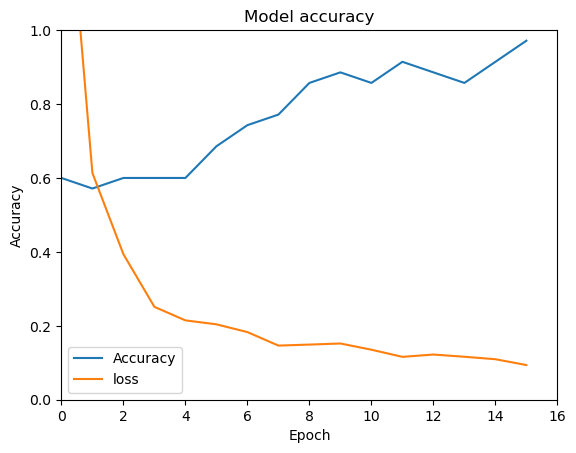

In [341]:
# create neural network input arrays
x_train_left, x_train_right, x_test_left, x_test_right, y_train, y_test = create_input_data(train_dataframe, test_dataframe, sequence_len)

# create model
model = siamese_model(sequence_len)

# train model
history = model.fit(x=[x_train_left, x_train_right], y=y_train, epochs=epochs_num, batch_size=batch_size)

# print history plot
print_history_plot(history, epochs_num)

Test Accuracy: 86.67%


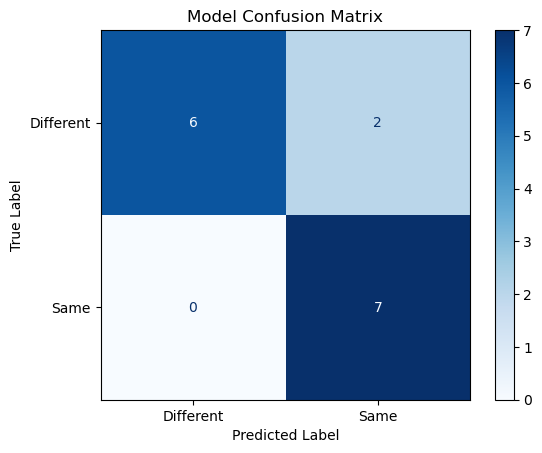

In [342]:
#Evaluate the model and print a confusion matrix for test set
test_loss, test_acc = model.evaluate([x_test_left, x_test_right], y_test, verbose=0) 
print('Test Accuracy: %.2f' % (test_acc * 100) + '%')

print_confusion_matrix(model, x_test_left, x_test_right, y_test)